In [84]:
#!pip install xgboost
from xgboost import XGBRegressor, plot_importance
import statsmodels as sm
#https://www.statsmodels.org/dev/vector_ar.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()
import datetime as dt
import warnings
warnings.simplefilter('ignore')
from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)
from sklearn.metrics import mean_squared_error # for calculating the cost function

In [85]:
train_df = pd.read_csv('/Users/aashrit/Documents/Masters/MY498/Data/Time Series/twitter_reddit_time_series_copy3.csv')
train_df = train_df.set_index('date')
#train = train.iloc[20:,:]
train_df

,overall_sentiment_score_20d_lag,overall_attention_score_20d_lag,BEIR,interest_rate_1yr_lag,commodities_1yr_lag,UNRATENSA_1yr_lag,UMCSENT_2wk_lag,WM2NS_1yr_lag,gdp_1yr_lag,USDEUR_1yr_lag
date,,,,,,,,,,
01/06/2021,26.4459,3.900597,2.460,0.05,99.875276,11.2,82.9,17915.4,19477.444,1.224100
02/06/2021,51.3641,2.348224,2.440,0.06,99.875276,11.2,82.9,17915.4,19477.444,1.221300
03/06/2021,48.4431,1.156789,2.420,0.06,99.875276,11.2,82.9,17915.4,19477.444,1.212200
04/06/2021,17.4456,0.903695,2.400,0.06,99.875276,11.2,82.9,17915.4,19477.444,1.217300
05/06/2021,28.1433,0.947890,2.400,0.07,99.875276,11.2,82.9,17915.4,19477.444,1.216933
...,...,...,...,...,...,...,...,...,...,...
27/05/2022,-56.0960,2.735565,2.630,0.06,155.100579,5.5,58.4,20235.1,22740.959,1.070900
28/05/2022,-4.0143,1.563207,2.630,0.05,155.100579,5.5,58.4,20235.1,22740.959,1.069733
29/05/2022,1.4806,3.380288,2.630,0.05,155.100579,5.5,58.4,20235.1,22740.959,1.071044


In [86]:
nobs = 31
df_train, df_test = train_df[0:-nobs], train_df[-nobs:]

In [87]:
X_train = df_train.drop(['BEIR'],axis=1)
y_train = df_train['BEIR']
X_test = df_test.drop(['BEIR'],axis=1)
y_test = df_test['BEIR']

In [88]:
def train_test_plot(model, X_train, X_test, name):
    """
    This will plot the actual values of CPI against the one fitted by the model
    We train the model until 2009 and then use it from 2009 onwards on the test features dataset
    """
    fig, ax = plt.subplots(figsize=(12,6))
    colors = sns.color_palette("deep", 8)
    plt.ylim(2.5,3)
    
    yvalues = pd.DataFrame(y_test)
    
    forecasted = list(model.predict(X_test)) # Use the model fit on features data from 2009 onwards
    df_fcast = pd.DataFrame({"Date": list(yvalues.index), "BEIR_fcast": forecasted})
    df_fcast = df_fcast.set_index("Date")
    
    df = pd.merge(yvalues, df_fcast, left_index=True, right_index=True)

    df["BEIR_fcast"].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed", color="forestgreen") # CPI fitted
    df["BEIR"].plot(ax=ax, legend=True, linewidth=1.5, linestyle="solid", color="salmon") # Actual CPI values
    
    ax.set_title("Forecasted BEIR vs. Actual BEIR")
    ax.set_ylabel("BEIR")
    ax.set_xlabel("Date")
    ax.legend(["Forecasted BEIR","Actual BEIR"])
    plt.savefig(name)
    print(df)

### No HP Optimisation

In [89]:
# Build XGBoost
# Normalize the features 
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

xgb = XGBRegressor(booster='gbtree')
xgb.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = xgb.predict(X_test_scaled)
y_pred
rmse = metrics.mean_squared_error(y_test, y_pred, squared = False)
error = (rmse/np.mean(y_test))*100
print(rmse)
print(error)
#We see that the RMSE is quite low compared to the mean (4.5% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 
#train_test_plot(model=xgb, X_train=X_train_scaled, X_test=X_test_scaled, name='xgboost_forecast')

0.22757231052400256
8.457503088503225


In [90]:
xgb.predict(X_test_scaled)

array([2.860032 , 2.8757305, 2.8884635, 2.8869555, 2.8792017, 2.8862216,
       2.8852508, 2.9124022, 2.9193327, 2.9225097, 2.8997238, 2.887019 ,
       2.902705 , 2.9059737, 2.8600075, 2.9232154, 2.9071693, 2.8738902,
       2.905556 , 2.8617458, 2.8714333, 2.9175813, 2.8773067, 2.9393508,
       2.8682635, 2.893574 , 2.8435376, 2.9024003, 2.8593388, 2.8953004,
       2.8238807], dtype=float32)

In [91]:
# Build XGBoost
# Normalize the features 

xgb = XGBRegressor(booster='gbtree')
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_pred
rmse = metrics.mean_squared_error(y_test, y_pred, squared = False)
error = (rmse/np.mean(y_test))*100
print(rmse)
print(error)
#We see that the RMSE is quite low compared to the mean (4.5% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 
#train_test_plot(model=xgb, X_train=X_train, X_test=X_test, name='xgboost_forecast')

0.22757231052400256
8.457503088503225


In [92]:
xgb.predict(X_test_scaled)

array([2.504855 , 2.537699 , 2.54069  , 2.5562997, 2.5503895, 2.5050232,
       2.5161006, 2.510685 , 2.5070047, 2.5133476, 2.5059447, 2.5136592,
       2.5159345, 2.5159345, 2.5185971, 2.4951751, 2.5486815, 2.5424008,
       2.5106926, 2.5092058, 2.5197732, 2.5148492, 2.5108511, 2.5481553,
       2.5524247, 2.5385091, 2.5421722, 2.5161006, 2.550817 , 2.5359936,
       2.54069  ], dtype=float32)

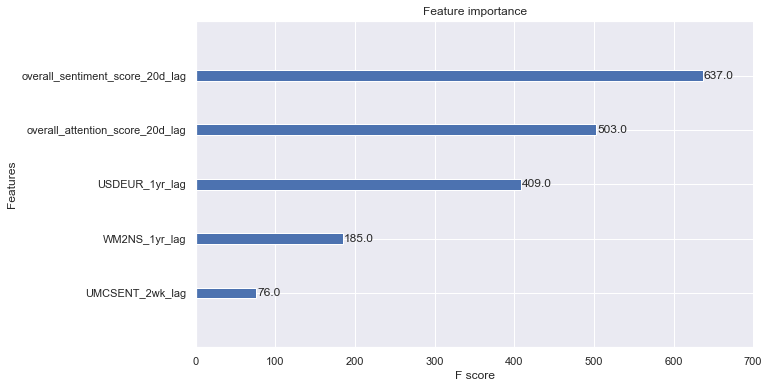

In [93]:
fig_xgb, ax_xgb = plt.subplots(figsize=(10,6))
plot_importance(xgb, max_num_features=5, ax=ax_xgb)
plt.savefig('xgboost_feature_importance.png', bbox_inches='tight')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

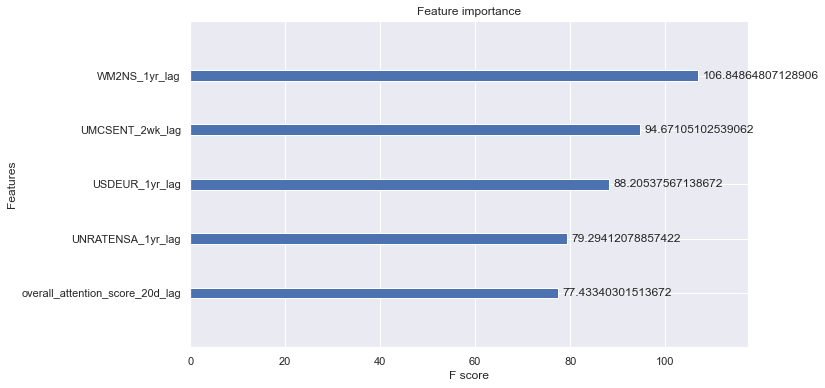

In [94]:
fig_xgb, ax_xgb = plt.subplots(figsize=(10,6))
plot_importance(xgb, max_num_features=5, ax=ax_xgb, importance_type = 'cover')
#plt.savefig('xgboost_feature_importance.png', bbox_inches='tight')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

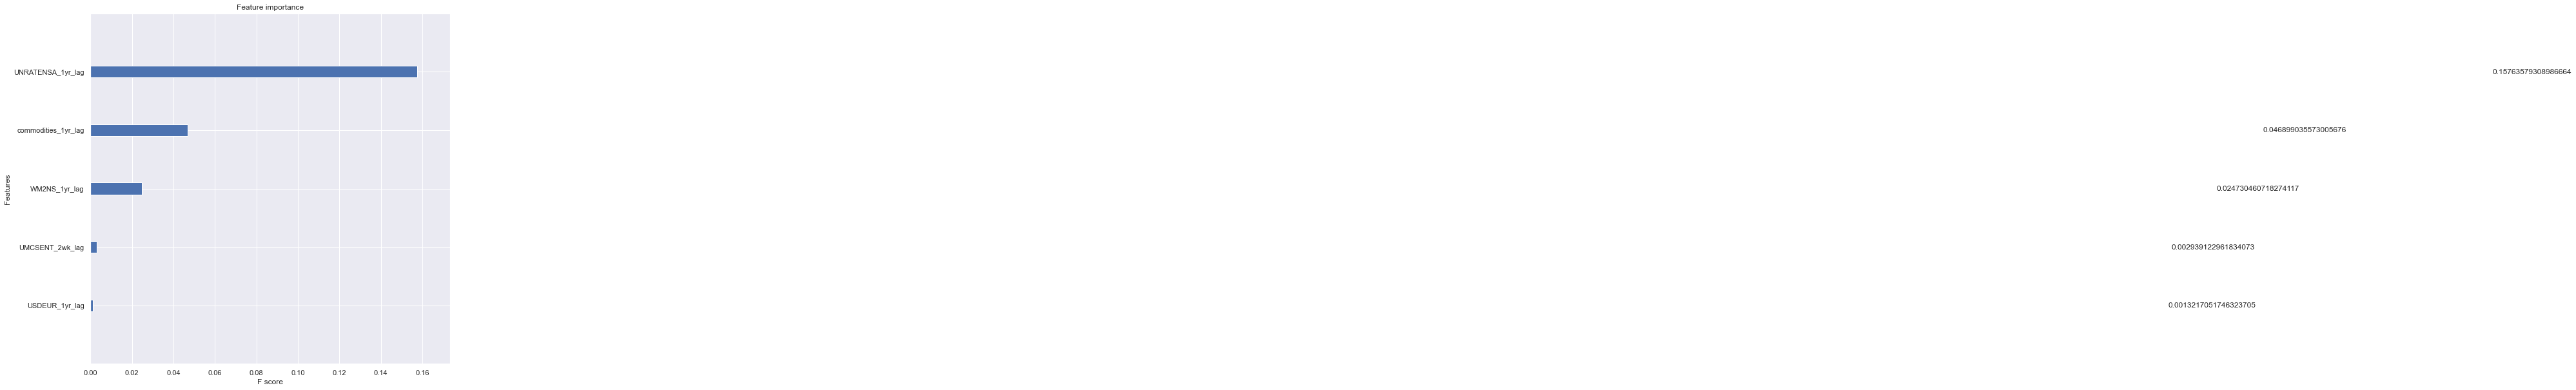

In [95]:
fig_xgb, ax_xgb = plt.subplots(figsize=(10,10))
plot_importance(xgb, max_num_features=5, ax=ax_xgb, importance_type = 'gain')
#plt.savefig('xgboost_feature_importance.png', bbox_inches='tight')

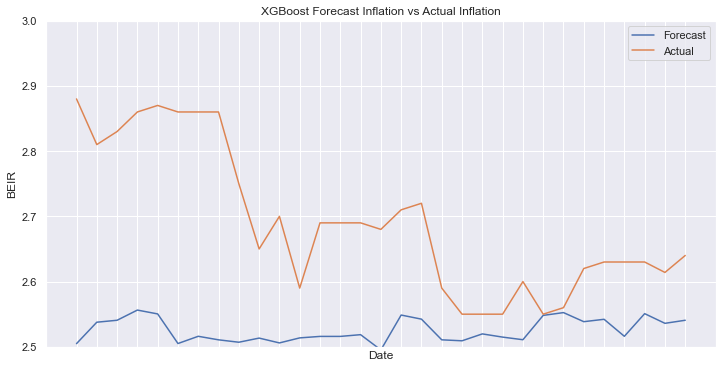

In [96]:
plt.figure(figsize=(12,6))
plt.plot(df_test.index, xgb.predict(X_test_scaled), label = "Forecast")
# plotting the line 2 points 
plt.plot(df_test.index, y_test, label = "Actual")
plt.xlabel('Date')
# Set the y axis label of the current axis.
plt.ylabel('BEIR')
# Set a title of the current axes.
plt.title('XGBoost Forecast Inflation vs Actual Inflation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylim(2.5,3)
# show a legend on the plot
plt.legend()
plt.savefig('xgboost_forecast.png')
# Display a figure.
plt.show()

In [97]:
y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred, columns = ['BEIR'])

In [98]:
y_pred

,BEIR
0,2.860032
1,2.875731
2,2.888463
3,2.886955
4,2.879202
5,2.886222
6,2.885251
7,2.912402
8,2.919333
9,2.922510


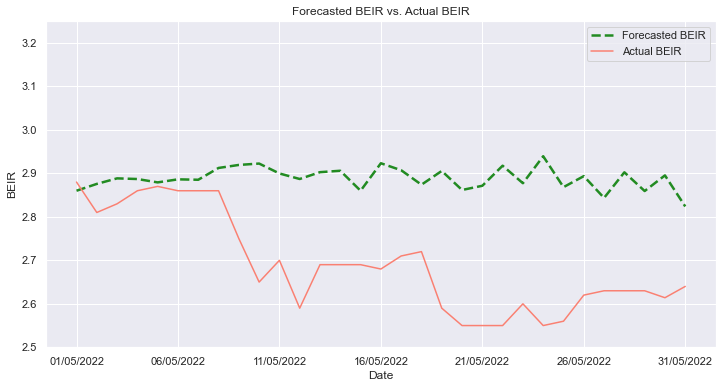

In [99]:
y_pred = xgb.predict(X_test)
y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred, columns = ['BEIR'])
fig, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette("deep", 8)
plt.ylim(2.5,3.25)
    
y_pred['BEIR'].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed", color="forestgreen") # CPI fitted
y_test["BEIR"].plot(ax=ax, legend=True, linewidth=1.5, linestyle="solid", color="salmon") # Actual CPI values
    
ax.set_title("Forecasted BEIR vs. Actual BEIR")
ax.set_ylabel("BEIR")
ax.set_xlabel("Date")
ax.legend(["Forecasted BEIR","Actual BEIR"])
#plt.savefig('var_forecast.png')

In [100]:
rmse = metrics.mean_squared_error(y_test, y_pred, squared = False)
error = (rmse/np.mean(y_test))*100
print(rmse)
print(error)
#We see that the RMSE is quite low compared to the mean (4.5% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 

0.22757231052400256
BEIR    8.457503
dtype: float64


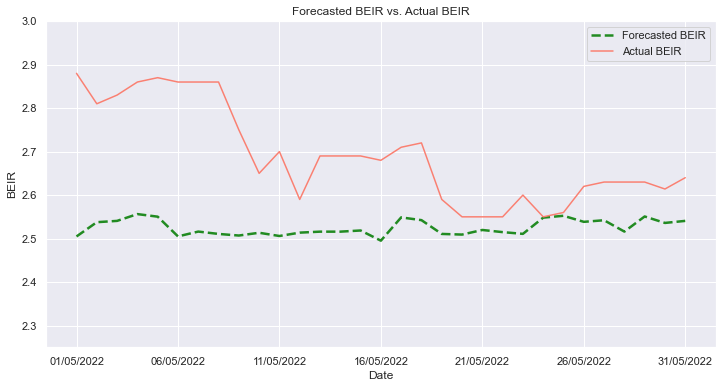

In [101]:
y_pred = xgb.predict(X_test_scaled)
y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred, columns = ['BEIR'])

fig, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette("deep", 8)
plt.ylim(2.25,3)
    
y_pred['BEIR'].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed", color="forestgreen") # CPI fitted
y_test["BEIR"].plot(ax=ax, legend=True, linewidth=1.5, linestyle="solid", color="salmon") # Actual CPI values
    
ax.set_title("Forecasted BEIR vs. Actual BEIR")
ax.set_ylabel("BEIR")
ax.set_xlabel("Date")
ax.legend(["Forecasted BEIR","Actual BEIR"])
#plt.savefig('var_forecast.png')

In [102]:
rmse = metrics.mean_squared_error(y_test, y_pred, squared = False)
error = (rmse/np.mean(y_test))*100
print(rmse)
print(error)
#We see that the RMSE is quite low compared to the mean (4.5% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 

0.19917792195760736
BEIR    7.402253
dtype: float64


             BEIR  BEIR_fcast
date                         
01/05/2022  2.880    2.504855
02/05/2022  2.810    2.537699
03/05/2022  2.830    2.540690
04/05/2022  2.860    2.556300
05/05/2022  2.870    2.550390
06/05/2022  2.860    2.505023
07/05/2022  2.860    2.516101
08/05/2022  2.860    2.510685
09/05/2022  2.750    2.507005
10/05/2022  2.650    2.513348
11/05/2022  2.700    2.505945
12/05/2022  2.590    2.513659
13/05/2022  2.690    2.515934
14/05/2022  2.690    2.515934
15/05/2022  2.690    2.518597
16/05/2022  2.680    2.495175
17/05/2022  2.710    2.548681
18/05/2022  2.720    2.542401
19/05/2022  2.590    2.510693
20/05/2022  2.550    2.509206
21/05/2022  2.550    2.519773
22/05/2022  2.550    2.514849
23/05/2022  2.600    2.510851
24/05/2022  2.550    2.548155
25/05/2022  2.560    2.552425
26/05/2022  2.620    2.538509
27/05/2022  2.630    2.542172
28/05/2022  2.630    2.516101
29/05/2022  2.630    2.550817
30/05/2022  2.614    2.535994
31/05/2022  2.640    2.540690


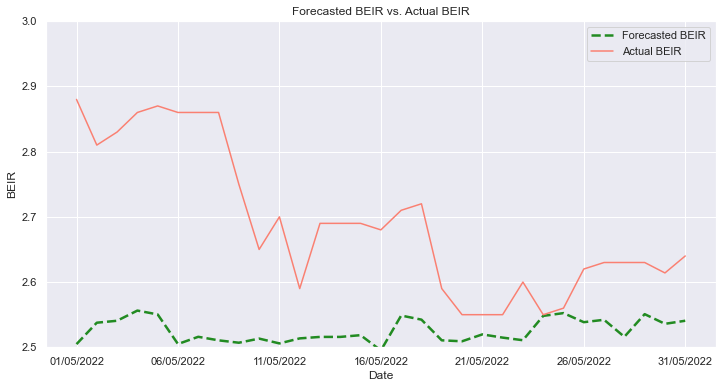

In [103]:
train_test_plot(model=xgb, X_train=X_train_scaled, X_test=X_test_scaled, name ='xgb_forecast')

In [104]:
for i, name in dict(zip(list(range(len(X_train.columns))), list(X_train.columns.values))).items():
    if i == 0:
        print(f"Feature {i} is {name}")
    elif i == 1:
        print(f"Feature {i} is {name}")
    elif i == 8:
        print(f"Feature {i} is {name}")
    elif i == 6:
        print(f"Feature {i} is {name}")
    elif i == 5:
        print(f"Feature {i} is {name}")

Feature 0 is overall_sentiment_score_20d_lag
Feature 1 is overall_attention_score_20d_lag
Feature 5 is UMCSENT_2wk_lag
Feature 6 is WM2NS_1yr_lag
Feature 8 is USDEUR_1yr_lag


In [105]:
y_pred = xgb.predict(X_test_scaled)
y_pred


array([2.504855 , 2.537699 , 2.54069  , 2.5562997, 2.5503895, 2.5050232,
       2.5161006, 2.510685 , 2.5070047, 2.5133476, 2.5059447, 2.5136592,
       2.5159345, 2.5159345, 2.5185971, 2.4951751, 2.5486815, 2.5424008,
       2.5106926, 2.5092058, 2.5197732, 2.5148492, 2.5108511, 2.5481553,
       2.5524247, 2.5385091, 2.5421722, 2.5161006, 2.550817 , 2.5359936,
       2.54069  ], dtype=float32)

In [106]:
rmse = metrics.mean_squared_error(y_test, y_pred, squared = False)
error = (rmse/np.mean(y_test))*100
print(rmse)
print(error)
#We see that the RMSE is quite low compared to the mean (4.5% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 

0.19917792195760736
BEIR    7.402253
dtype: float64


In [107]:
xgb.get_booster()

### With Grid Search

In [108]:
from sklearn.model_selection import GridSearchCV

xgb_opt = XGBRegressor()

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
learning_rate = [i for i in np.arange(0.001,0.1,0.001)]

grid = {'n_estimators': n_estimators,

'max_depth': max_depth,

'learning_rate': learning_rate}

xgb_opt_grid = GridSearchCV(estimator = xgb_opt, param_grid = grid, cv = 5, n_jobs = -1)

xgb_opt_grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                           0.013000000000000001,
                                           0.014000000000000002, 0.015, 0.016,
                                           0.017, 0.018000000000000002,
                                        

             BEIR  BEIR_fcast
date                         
01/05/2022  2.880    2.657388
02/05/2022  2.810    2.653764
03/05/2022  2.830    2.664643
04/05/2022  2.860    2.681165
05/05/2022  2.870    2.658712
06/05/2022  2.860    2.660505
07/05/2022  2.860    2.650797
08/05/2022  2.860    2.658712
09/05/2022  2.750    2.658712
10/05/2022  2.650    2.658712
11/05/2022  2.700    2.658712
12/05/2022  2.590    2.665852
13/05/2022  2.690    2.658339
14/05/2022  2.690    2.657160
15/05/2022  2.690    2.657160
16/05/2022  2.680    2.658712
17/05/2022  2.710    2.660505
18/05/2022  2.720    2.658712
19/05/2022  2.590    2.657160
20/05/2022  2.550    2.657160
21/05/2022  2.550    2.655523
22/05/2022  2.550    2.658712
23/05/2022  2.600    2.654209
24/05/2022  2.550    2.658712
25/05/2022  2.560    2.658712
26/05/2022  2.620    2.658712
27/05/2022  2.630    2.660505
28/05/2022  2.630    2.658568
29/05/2022  2.630    2.655758
30/05/2022  2.614    2.664643
31/05/2022  2.640    2.664643


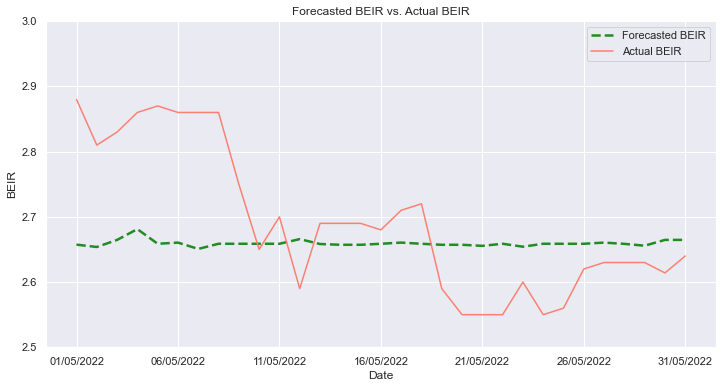

In [109]:
xgb_opt.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

train_test_plot(model=xgb_opt, X_train=X_train_scaled, X_test=X_test, name ='xgb_opt_forecast')

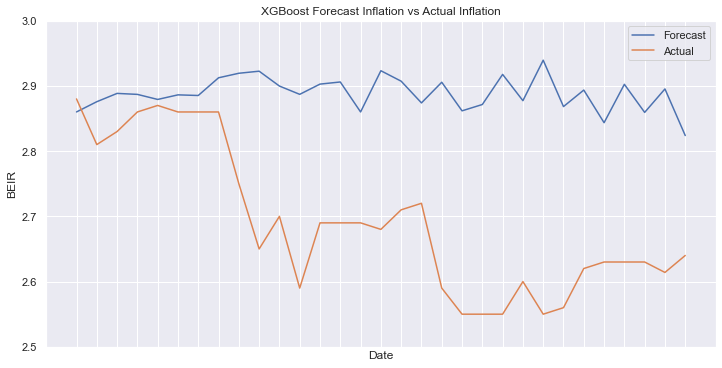

In [110]:
plt.figure(figsize=(12,6))
plt.plot(df_test.index, xgb_opt.predict(X_test_scaled), label = "Forecast")
# plotting the line 2 points 
plt.plot(df_test.index, y_test, label = "Actual")
plt.xlabel('Date')
# Set the y axis label of the current axis.
plt.ylabel('BEIR')
# Set a title of the current axes.
plt.title('XGBoost Forecast Inflation vs Actual Inflation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylim(2.5,3)
# show a legend on the plot
plt.legend()
plt.savefig('xgboost_forecast.png')
# Display a figure.
plt.show()

In [111]:
rmse_xgb_opt = metrics.mean_squared_error(y_test, xgb_opt.predict(X_test_scaled), squared = False)
error_xgb_opt = (rmse_xgb_opt/np.mean(y_test))*100
print(rmse_xgb_opt)
print(error_xgb_opt)
#We see that the RMSE is quite low compared to the mean (4.5% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 

0.22757231052400256
BEIR    8.457503
dtype: float64


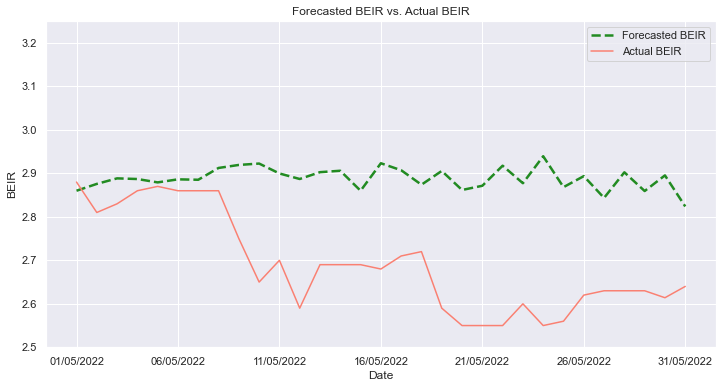

In [112]:
y_pred = xgb.predict(X_test)
y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred, columns = ['BEIR'])
fig, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette("deep", 8)
plt.ylim(2.5,3.25)
    
y_pred['BEIR'].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed", color="forestgreen") # CPI fitted
y_test["BEIR"].plot(ax=ax, legend=True, linewidth=1.5, linestyle="solid", color="salmon") # Actual CPI values
    
ax.set_title("Forecasted BEIR vs. Actual BEIR")
ax.set_ylabel("BEIR")
ax.set_xlabel("Date")
ax.legend(["Forecasted BEIR","Actual BEIR"])
#plt.savefig('var_forecast.png')

In [114]:
rmse_xgb_opt = metrics.mean_squared_error(y_test, xgb_opt.predict(X_test), squared = False)
error_xgb_opt = (rmse_xgb_opt/np.mean(y_test))*100
print(rmse_xgb_opt)
print(error_xgb_opt)
#y_pred = xgb_opt.predict(X_test)
#We see that the RMSE is quite low compared to the mean (4.5% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 

0.11334071065649805
BEIR    4.212197
dtype: float64


In [116]:
y_pred = xgb_opt.predict(X_test)
y_pred

array([2.657388 , 2.6537645, 2.6646428, 2.6811647, 2.6587117, 2.6605046,
       2.6507971, 2.6587117, 2.6587117, 2.6587117, 2.6587117, 2.6658523,
       2.6583388, 2.6571596, 2.6571596, 2.6587117, 2.6605046, 2.6587117,
       2.6571596, 2.6571596, 2.655523 , 2.6587117, 2.6542094, 2.6587117,
       2.6587117, 2.6587117, 2.6605046, 2.6585681, 2.6557577, 2.6646428,
       2.6646428], dtype=float32)

In [117]:
print(max(xgb_opt.predict(X_test)))
print(min(xgb_opt.predict(X_test)))

2.6811647
2.6507971


In [32]:
##n_estimators
#max_depth
#learning_rate

In [33]:
print(max(xgb.predict(X_test_scaled)))
print(min(xgb.predict(X_test_scaled)))

2.5562997
2.4951751


### With Random Search

In [34]:
from sklearn.model_selection import RandomizedSearchCV

xgb_rand_opt = XGBRegressor()

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
learning_rate = [i for i in np.arange(0.001,0.1,0.001)]

grid = {'n_estimators': n_estimators,

'max_depth': max_depth,

'learning_rate': learning_rate}

xgb_rand_opt_grid = RandomizedSearchCV(estimator = xgb_rand_opt, param_distributions = grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

xgb_rand_opt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                                          0.014000000000000002,
                          

In [35]:
xgb_rand_opt_grid.best_params_

{'n_estimators': 17, 'max_depth': 60, 'learning_rate': 0.098}

             BEIR  BEIR_fcast
date                         
01/05/2022  2.880    2.860032
02/05/2022  2.810    2.875731
03/05/2022  2.830    2.888463
04/05/2022  2.860    2.886955
05/05/2022  2.870    2.879202
06/05/2022  2.860    2.886222
07/05/2022  2.860    2.885251
08/05/2022  2.860    2.912402
09/05/2022  2.750    2.919333
10/05/2022  2.650    2.922510
11/05/2022  2.700    2.899724
12/05/2022  2.590    2.887019
13/05/2022  2.690    2.902705
14/05/2022  2.690    2.905974
15/05/2022  2.690    2.860008
16/05/2022  2.680    2.923215
17/05/2022  2.710    2.907169
18/05/2022  2.720    2.873890
19/05/2022  2.590    2.905556
20/05/2022  2.550    2.861746
21/05/2022  2.550    2.871433
22/05/2022  2.550    2.917581
23/05/2022  2.600    2.877307
24/05/2022  2.550    2.939351
25/05/2022  2.560    2.868263
26/05/2022  2.620    2.893574
27/05/2022  2.630    2.843538
28/05/2022  2.630    2.902400
29/05/2022  2.630    2.859339
30/05/2022  2.614    2.895300
31/05/2022  2.640    2.823881


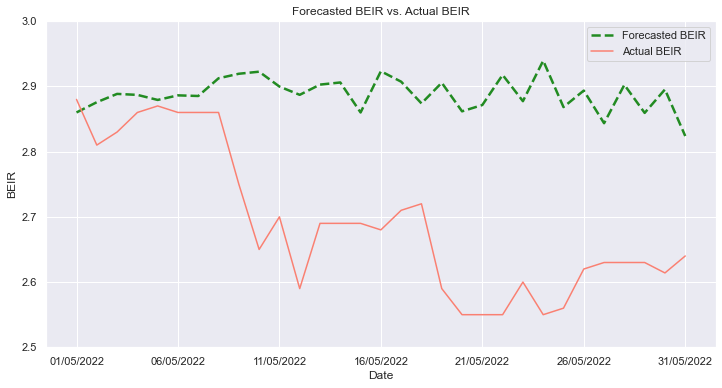

In [36]:
xgb_rand_opt.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

train_test_plot(model=xgb_rand_opt, X_train=X_train_scaled, X_test=X_test_scaled, name ='xgb_rand_opt_forecast')

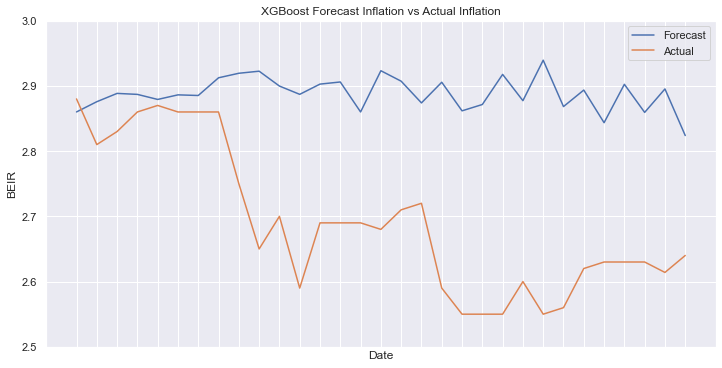

In [37]:
plt.figure(figsize=(12,6))
plt.plot(df_test.index, xgb_rand_opt.predict(X_test_scaled), label = "Forecast")
# plotting the line 2 points 
plt.plot(df_test.index, y_test, label = "Actual")
plt.xlabel('Date')
# Set the y axis label of the current axis.
plt.ylabel('BEIR')
# Set a title of the current axes.
plt.title('XGBoost Forecast Inflation vs Actual Inflation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylim(2.5,3)
# show a legend on the plot
plt.legend()
plt.savefig('xgboost_forecast.png')
# Display a figure.
plt.show()

In [38]:
rmse_xgb_rand_opt = metrics.mean_squared_error(y_test, xgb_rand_opt.predict(X_test_scaled), squared = False)
error_xgb_rand_opt = (rmse_xgb_rand_opt/np.mean(y_test))*100
print(rmse_xgb_rand_opt)
print(error_xgb_rand_opt)
#We see that the RMSE is quite low compared to the mean (4.5% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 

0.22757231052400256
BEIR    8.457503
dtype: float64


In [39]:
#RF

In [40]:
from sklearn.ensemble import RandomForestRegressor # for building the model

In [41]:
# Initializing the Random Forest Regression model with 10 decision trees
model = RandomForestRegressor(n_estimators = 10, random_state = 0)

# Fitting the Random Forest Regression model to the data
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [42]:
# Predicting the target values of the test set
y_pred = model.predict(X_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  0.206


In [43]:
def train_test_plot(model, X_train, X_test, name):
    """
    This will plot the actual values of CPI against the one fitted by the model
    We train the model until 2009 and then use it from 2009 onwards on the test features dataset
    """
    fig, ax = plt.subplots(figsize=(12,6))
    colors = sns.color_palette("deep", 8)
    plt.ylim(2.5,3)
    
    yvalues = pd.DataFrame(y_test)
    
    forecasted = list(model.predict(X_test)) # Use the model fit on features data from 2009 onwards
    df_fcast = pd.DataFrame({"Date": list(yvalues.index), "BEIR_fcast": forecasted})
    df_fcast = df_fcast.set_index("Date")
    
    df = pd.merge(yvalues, df_fcast, left_index=True, right_index=True)

    df["BEIR_fcast"].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed", color="forestgreen") # CPI fitted
    df["BEIR"].plot(ax=ax, legend=True, linewidth=1.5, linestyle="solid", color="salmon") # Actual CPI values
    
    ax.set_title("Forecasted BEIR vs. Actual BEIR")
    ax.set_ylabel("BEIR")
    ax.set_xlabel("Date")
    ax.legend(["Forecasted BEIR","Actual BEIR"])
    plt.savefig(name)
    print(df)

             BEIR  BEIR_fcast
date                         
01/05/2022  2.880      2.8940
02/05/2022  2.810      2.9020
03/05/2022  2.830      2.9050
04/05/2022  2.860      2.9050
05/05/2022  2.870      2.9090
06/05/2022  2.860      2.9070
07/05/2022  2.860      2.8930
08/05/2022  2.860      2.9070
09/05/2022  2.750      2.9170
10/05/2022  2.650      2.9030
11/05/2022  2.700      2.9070
12/05/2022  2.590      2.8986
13/05/2022  2.690      2.8980
14/05/2022  2.690      2.9010
15/05/2022  2.690      2.8780
16/05/2022  2.680      2.8580
17/05/2022  2.710      2.8610
18/05/2022  2.720      2.8470
19/05/2022  2.590      2.8510
20/05/2022  2.550      2.8400
21/05/2022  2.550      2.8616
22/05/2022  2.550      2.8540
23/05/2022  2.600      2.8550
24/05/2022  2.550      2.8590
25/05/2022  2.560      2.8390
26/05/2022  2.620      2.8390
27/05/2022  2.630      2.8490
28/05/2022  2.630      2.8920
29/05/2022  2.630      2.8390
30/05/2022  2.614      2.8450
31/05/2022  2.640      2.8220


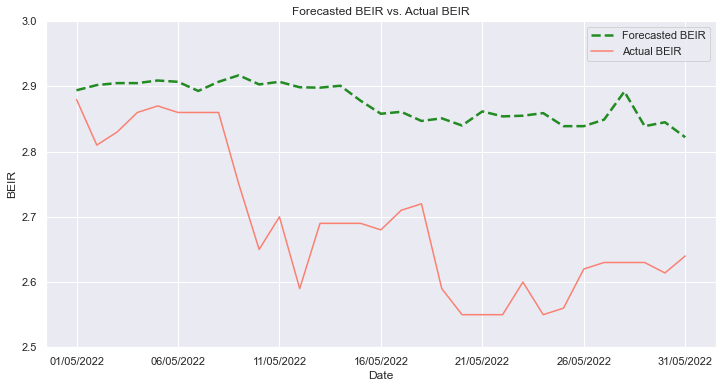

In [44]:
train_test_plot(model, X_train, X_test, 'rf_forecast.png')

In [53]:
X_train1 = df_train.drop(['BEIR','overall_sentiment_score_20d_lag','overall_attention_score_20d_lag'],axis=1)
y_train = df_train['BEIR']
X_test1 = df_test.drop(['BEIR','overall_sentiment_score_20d_lag','overall_attention_score_20d_lag'],axis=1)
y_test = df_test['BEIR']

In [54]:
# Build XGBoost
# Normalize the features 
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train1)

xgb = XGBRegressor(booster='gbtree')
xgb.fit(X_train1, y_train)

X_test_scaled = scaler.transform(X_test1)

y_pred = xgb.predict(X_test1)
y_pred
rmse = metrics.mean_squared_error(y_test, y_pred, squared = False)
error = (rmse/np.mean(y_test))*100
print(rmse)
print(error)
#We see that the RMSE is quite low compared to the mean (4.5% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 
#train_test_plot(model=xgb, X_train=X_train_scaled, X_test=X_test_scaled, name='xgboost_forecast')

0.22111390289745395
8.217482664565988


In [118]:
# Build XGBoost
# Normalize the features 
scaler = preprocessing.StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_train1)

xgb_opt.fit(X_train_scaled1, y_train)

X_test_scaled1 = scaler.transform(X_test1)

y_pred2 = xgb_opt.predict(X_test_scaled1)

rmse = metrics.mean_squared_error(y_test, y_pred2, squared = False)
error = (rmse/np.mean(y_test))*100
print(rmse)
print(error)


0.22111390289745395
BEIR    8.217483
dtype: float64


In [119]:
rmse_xgb_opt = metrics.mean_squared_error(y_test, xgb_opt.predict(X_test_scaled1), squared = False)
error_xgb_opt = (rmse_xgb_opt/np.mean(y_test))*100
print(rmse_xgb_opt)
print(error_xgb_opt)
#We see that the RMSE is quite low compared to the mean (4.5% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 

0.22111390289745395
BEIR    8.217483
dtype: float64


In [120]:
y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred)
y_pred2 = pd.DataFrame(y_pred2)
y_test.columns = ['BEIR']
y_pred.columns = ['BEIR_forecast']
y_pred2.columns = ['BEIR_forecast']

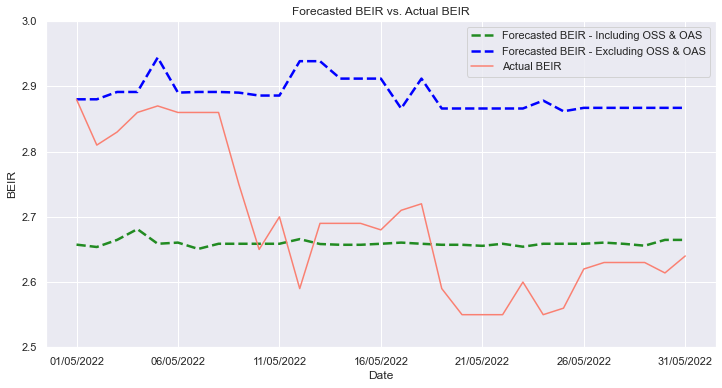

In [123]:
fig, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette("deep", 8)
plt.ylim(2.5,3)
    
yvalues = pd.DataFrame(y_test)
    
y_pred['BEIR_forecast'].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed", color="forestgreen") # CPI fitted
y_pred2['BEIR_forecast'].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed", color="blue") # CPI fitted
y_test['BEIR'].plot(ax=ax, legend=True, linewidth=1.5, linestyle="solid", color="salmon") # Actual CPI values
    
ax.set_title("Forecasted BEIR vs. Actual BEIR")
ax.set_ylabel("BEIR")
ax.set_xlabel("Date")
ax.legend(["Forecasted BEIR - Including OSS & OAS","Forecasted BEIR - Excluding OSS & OAS",'Actual BEIR'])
plt.savefig('xgb_forecast_14-08.png')

In [127]:
y_pred.to_csv('xgb.csv')
y_test.to_csv('test.csv')